In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from contrastive_hebbian_net import ContrastiveNet, generate_tuned_weights
from angle_discrimination_task import AngleDiscriminationTask
from multi_layer_contrastive import MultiLayerContrastiveNet

In [2]:
# Task parameters
training_orientation = 90.0
orientation_diff = 1
input_size = 100
signal_amp = 1.0
signal_bandwidth = 15
output_amp = 1.0

# Model parameters
hidden_dim = 40
learning_rate = 1e-3
test_epochs = 10
epochs = 10000
tuned_neurons_width = 8
weight_reg = 0.1


all_regimes = {"contrastive_hebb": {"gamma": 1.0, "eta": 0.0},
               "gradient_descent": {"gamma": 0.0, "eta": 0.0},
               "quasi_predictive": {"gamma": -1.0, "eta": 0.0},
               "hebbian": {"gamma": 0, "eta": 0.01},
               "anti_hebbian": {"gamma": 0, "eta": -0.01}}

In [3]:
data = AngleDiscriminationTask(training_orientation=training_orientation,
                               orientation_diff=orientation_diff,
                               input_size=input_size,
                               signal_amp=signal_amp,
                               signal_bandwidth=signal_bandwidth,
                               output_amp=output_amp)

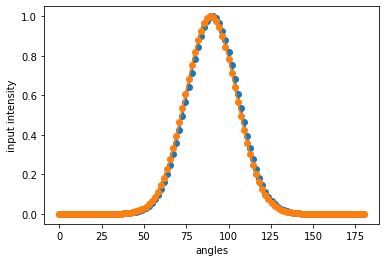

In [4]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(data.angles, data.pos_gaussian, "-o")
ax.plot(data.angles, data.neg_gaussian, "-o")
ax.set_xlabel("angles")
ax.set_ylabel("input intensity")
plt.show()

In [5]:
h_angles = np.linspace(0, 180, num=hidden_dim)

W1_0 = generate_tuned_weights(input_size, hidden_dim=hidden_dim, angles=data.angles, tuning_width=tuned_neurons_width)
W2_0 = generate_tuned_weights(hidden_dim, hidden_dim=hidden_dim, angles=h_angles, tuning_width=tuned_neurons_width)
W3_0 = generate_tuned_weights(hidden_dim, hidden_dim=hidden_dim, angles=h_angles, tuning_width=tuned_neurons_width)
W4_0 = np.zeros((data.output_size, hidden_dim))

W_list = [W1_0, W2_0, W3_0, W4_0]

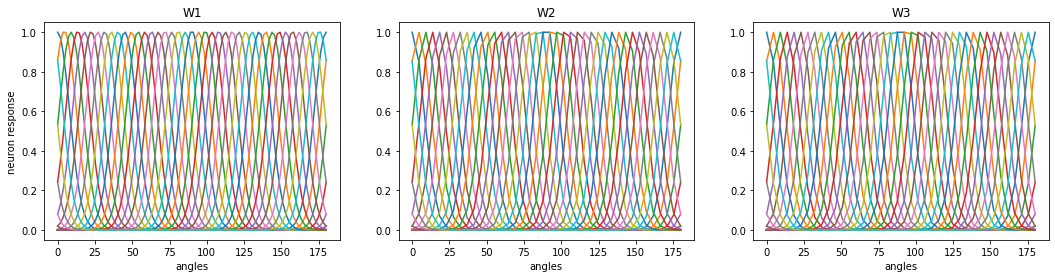

In [6]:
f, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(hidden_dim):
    ax[0].plot(data.angles, W1_0[i, :])
    ax[1].plot(h_angles, W2_0[i, :])
    ax[2].plot(h_angles, W3_0[i, :])
ax[0].set_xlabel("angles")
ax[1].set_xlabel("angles")
ax[2].set_xlabel("angles")
ax[0].set_title("W1")
ax[1].set_title("W2")
ax[2].set_title("W3")
ax[0].set_ylabel("neuron response")
plt.show()

In [7]:
save_every = 10
regime_results = {}
for key, values in all_regimes.items():
    aux_dict = {}
    total_loss = []
    grad_list = []
    weight_list = []
    
    net = MultiLayerContrastiveNet(W_list, gamma=values["gamma"], eta=values["eta"], learning_rate=learning_rate)
    for i in tqdm(range(epochs)):
        if i % save_every == 0:
            weight_list.append(net.W_list)
        x, y = data.full_batch()
        loss, all_updates = net.update(x, y)
        total_loss.append(loss)
        if i % save_every == 0:
            grad_list.append(all_updates)
    #RSM = h_ff[:, :, 0] @ h_ff[:, :, 0].T
    #aux_dict["RSM"] = RSM
    aux_dict["loss"] = total_loss
    aux_dict["learned_W"] = weight_list
    aux_dict["W_grad"] = grad_list
    regime_results[key] = aux_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:14<00:00, 74.18it/s]


In [8]:
# for key, values in regime_results.items():
#     print(len(values["learned_W"]))
#     for W in values["learned_W"]:
#         for w in W:
#             print(np.mean(w))

In [9]:
def slope_per_angle(W):
    # print(W.shape, W[:, 0][:, np.newaxis].shape)
    slopes = np.diff(np.concatenate([W, W[:, 1][:, np.newaxis]], axis=1), axis=1)
    slope_ori = np.mean(np.abs(slopes), axis=0)
    return slope_ori

def change_in_slope(W_new, W_0):
    slope_0 = slope_per_angle(W_0)
    slope_1 = slope_per_angle(W_new)
    return slope_1 - slope_0

def amplitude_change(W_new, W_0):
    amp0 = np.mean(W_0, axis=0)
    amp1 = np.mean(W_new, axis=0)
    return amp1 - amp0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


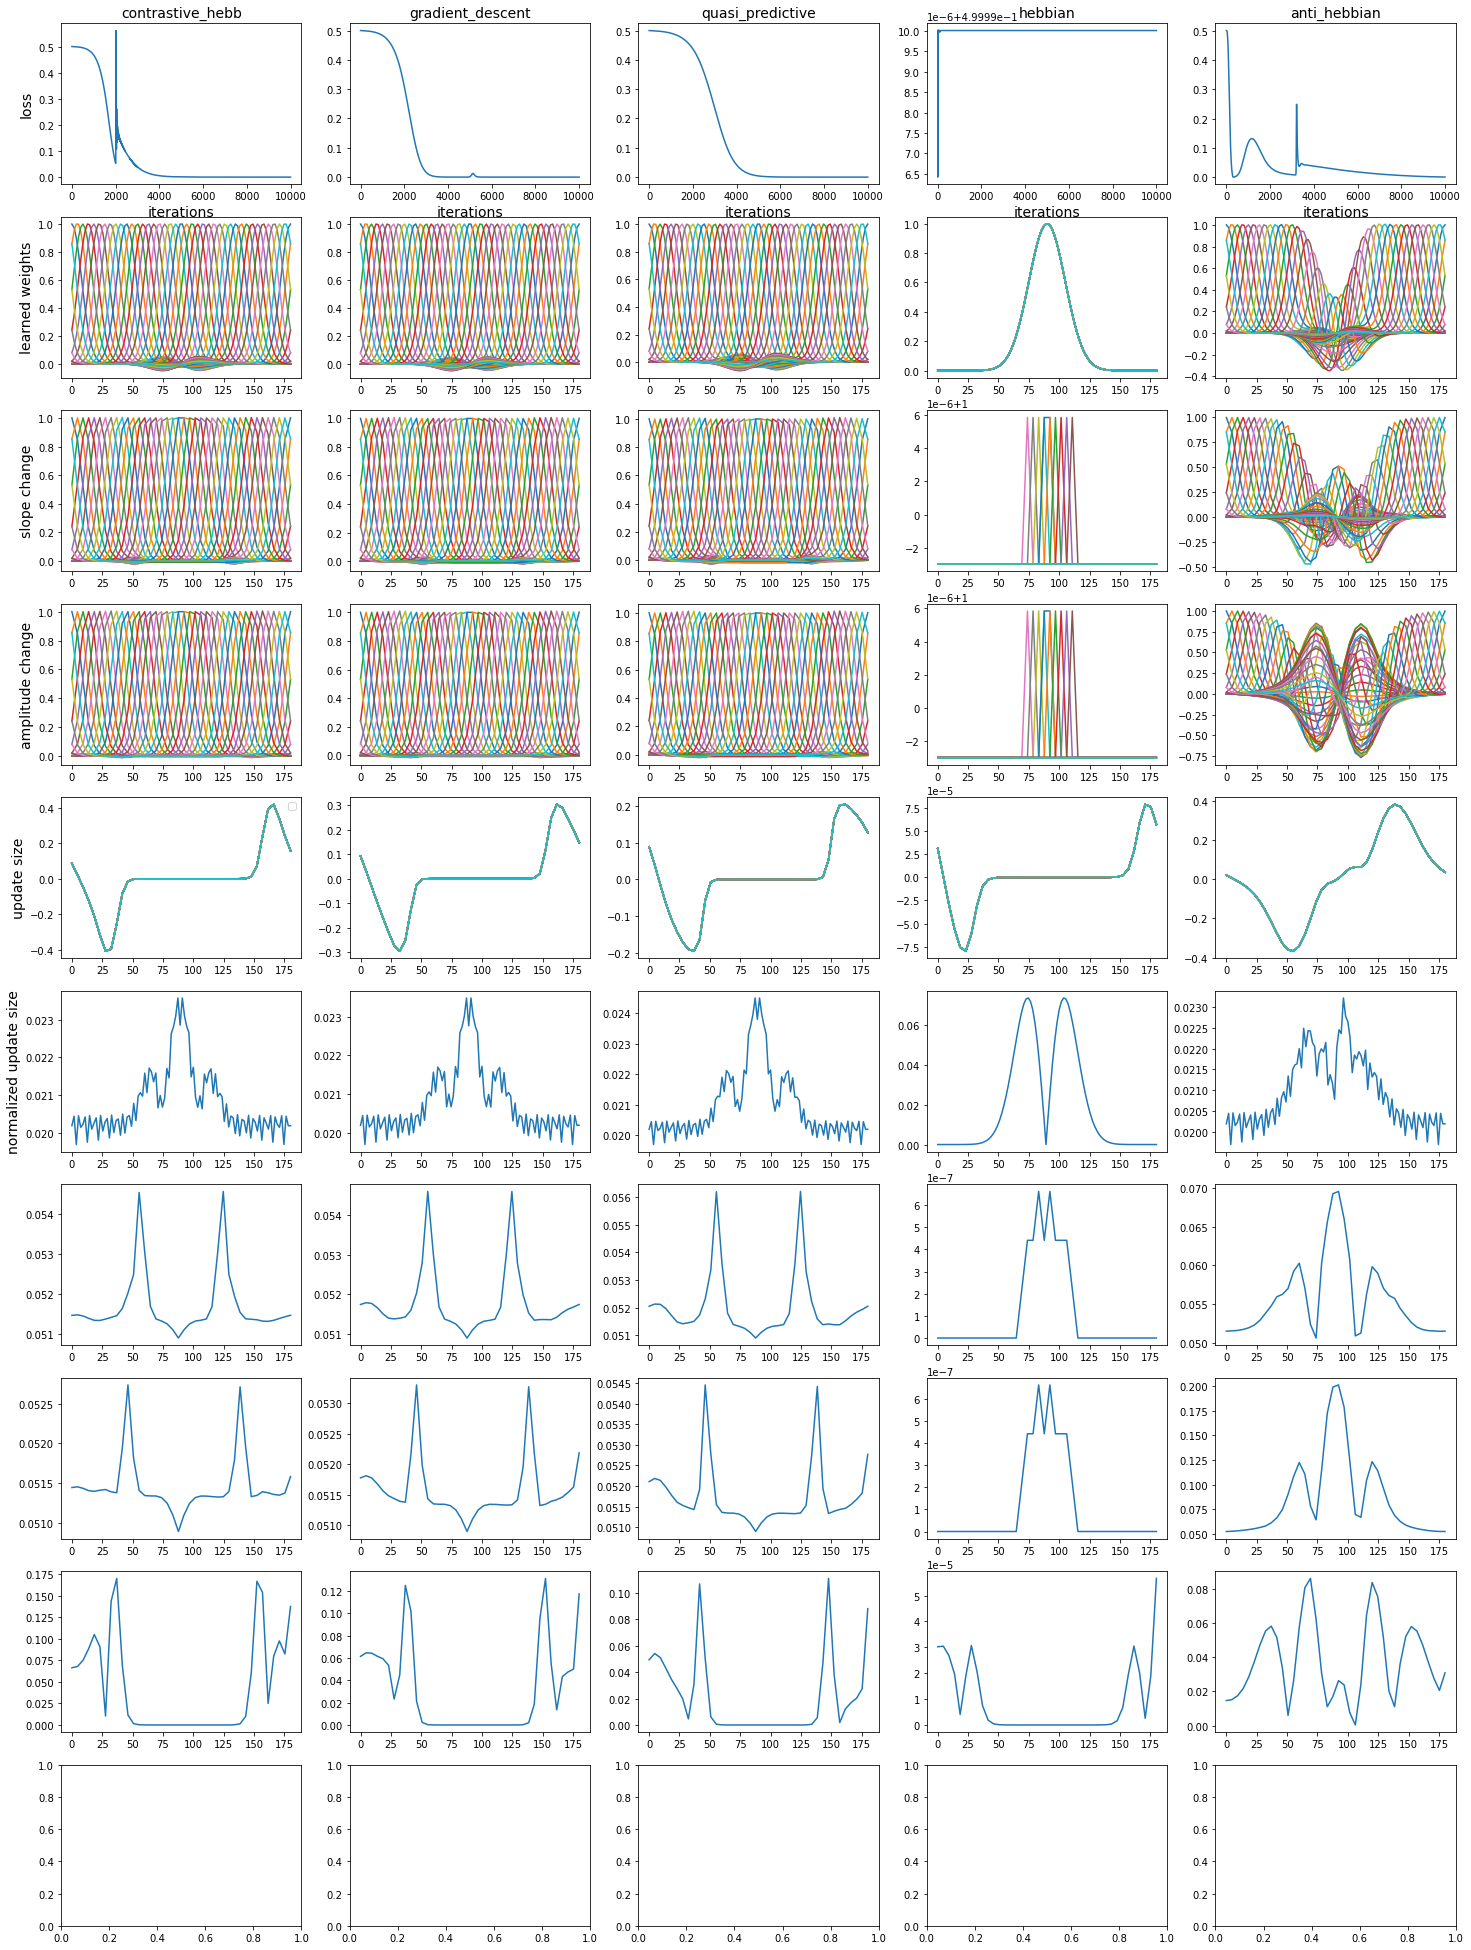

In [21]:
fontsize=14
f, ax = plt.subplots(10, len(regime_results), figsize=(5*len(regime_results), 35))
for i, (key, value) in enumerate(regime_results.items()):
    ax[0, i].plot(value["loss"])
    ax[0, i].set_title(key, fontsize=fontsize)
    ax[0, i].set_xlabel("iterations", fontsize=fontsize)
    
    for j in range(hidden_dim):
        ax[1, i].plot(data.angles, value["learned_W"][-1][0][j, :])
        
    for j in range(hidden_dim):
        ax[2, i].plot(h_angles, value["learned_W"][-1][1][j, :])
        
    for j in range(hidden_dim):
        ax[3, i].plot(h_angles, value["learned_W"][-1][2][j, :])
    
    for j in range(hidden_dim):
        ax[4, i].plot(h_angles, value["learned_W"][-1][3][j, :])
    
    ax[5, i].plot(data.angles, slope_per_angle(value["learned_W"][-1][0]))
    
    ax[6, i].plot(h_angles, slope_per_angle(value["learned_W"][-1][1]))
    
    ax[7, i].plot(h_angles, slope_per_angle(value["learned_W"][-1][2]))
    
    ax[8, i].plot(h_angles, slope_per_angle(value["learned_W"][-1][3]))
#     ax[2, i].plot(data.angles, change_in_slope(value["learned_W1"], W1_0))
#     ax[2, i].set_xlabel("orientations", fontsize=fontsize)
    
#     ax[3, i].plot(data.angles, amplitude_change(value["learned_W1"], W1_0))
#     ax[3, i].set_xlabel("orientations", fontsize=fontsize)
    
#     plot_index = 4
#     ax[plot_index, i].plot(value["W2_grad"], label="W2 grad")
#     ax[plot_index, i].plot(value["W1_grad"], label="W1 grad")
#     ax[plot_index, i].set_yscale("log")
#     ax[plot_index, i].set_xlabel("iterations", fontsize=fontsize)
    
#     plot_index = 5
#     ax[plot_index, i].plot(value["W2_grad"]/np.amax(value["W2_grad"]), label="norm W2 grad")
#     ax[plot_index, i].plot(value["W1_grad"]/np.amax(value["W1_grad"]), label="norm W1 grad")
#     ax[plot_index, i].set_yscale("log")
#     ax[plot_index, i].set_xlabel("iterations", fontsize=fontsize)
    

ax[0, 0].set_ylabel("loss", fontsize=fontsize)
ax[1, 0].set_ylabel("learned weights", fontsize=fontsize)
ax[2, 0].set_ylabel("slope change", fontsize=fontsize)
ax[3, 0].set_ylabel("amplitude change", fontsize=fontsize)
ax[4, 0].legend()
ax[4, 0].set_ylabel("update size", fontsize=fontsize)
ax[5, 0].set_ylabel("normalized update size", fontsize=fontsize)

plt.savefig("multi_layer.pdf", bbox_inches="tight")

#ax[1, i].imshow(value["RSM"])
    #print(value["RSM"].shape)

In [11]:
import pickle
pickle.dump(regime_results, open("regime_results", "wb"), protocol=pickle.HIGHEST_PROTOCOL)